# Comprehensive Cryptocurrency Analysis

## 103 Cryptocurrencies (2010-2026) - Feature Engineering & Market Insights

This notebook provides a comprehensive analysis of 103 cryptocurrency datasets spanning from 2010 to 2026, including:

- **Data Quality Assessment**: Missing data, coverage analysis, outlier detection
- **Market Overview**: Price evolution, volatility patterns, correlation analysis
- **Feature Engineering Analysis**: 50+ technical indicators and their distributions
- **Cross-Asset Analysis**: Market regimes, correlation matrices, relative performance
- **Time Series Decomposition**: Trend, seasonality, and cyclical patterns
- **Statistical Insights**: Risk-return profiles, performance metrics

---


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from pathlib import Path
import json
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
import yfinance as yf

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Cryptocurrency Analysis Notebook Loaded")
print("Data paths configured")
print("Plotting libraries initialized")

Cryptocurrency Analysis Notebook Loaded
Data paths configured
Plotting libraries initialized


## 1. Data Loading and Overview

Load the processed cryptocurrency data with engineered features.


In [ ]:
# Load feature-engineered data
features_path = "../data/features/"
processed_path = "../data/processed/"

# Load feature summary
with open(f"{features_path}/feature_engineering_summary.json", 'r') as f:
    feature_summary = json.load(f)

print("DATASET OVERVIEW")
print("=" * 50)
print(f"Total Cryptocurrencies: {feature_summary['total_cryptocurrencies']}")
print(f"Features per Crypto: {feature_summary['total_features']}")
print(f"Engineered Features: {feature_summary['engineered_features']}")
print(f"Original Features: {feature_summary['original_features']}")
print()
print("FEATURE CATEGORIES:")
for category, count in feature_summary['feature_categories'].items():
    if count > 0:
        print(f"  {category.replace('_', ' ').title()}: {count} features")

DATASET OVERVIEW
Total Cryptocurrencies: 104
Features per Crypto: 155
Engineered Features: 150
Original Features: 5

FEATURE CATEGORIES:
  Price Features: 40 features
  Moving Averages: 29 features
  Momentum Indicators: 16 features
  Volatility Indicators: 25 features
  Statistical Features: 11 features
  Correlation Features: 11 features
  Regime Features: 5 features
  Time Features: 14 features
  Support Resistance: 8 features


In [ ]:
# Load individual cryptocurrency data
crypto_data = {}
feature_files = list(Path(features_path).glob("*_features.parquet"))

print(f"Loading {len(feature_files)} cryptocurrency datasets...")


for file_path in feature_files[:40]:  
    crypto_name = file_path.stem.replace('_features', '')
    try:
        df = pd.read_parquet(file_path)
        crypto_data[crypto_name] = df
        print(f"{crypto_name}: {len(df)} records, {len(df.columns)} features")
    except Exception as e:
        print(f"Error loading {crypto_name}: {e}")

print(f"\nLoaded {len(crypto_data)} cryptocurrencies for analysis")

       # Display some of the major cryptocurrencies if they exist
major_cryptos = ['BTC', 'ETH', 'DOGE', 'LTC', 'ADA', 'XRP', 'SOL', 'MATIC']
found_major = [crypto for crypto in major_cryptos if crypto in crypto_data.keys()]
if found_major:
    print(f"Major cryptocurrencies found: {', '.join(found_major)}")
else:
    print("Searching for major cryptocurrencies in loaded data...")
    all_cryptos = list(crypto_data.keys())
    print(f"All loaded cryptocurrencies: {', '.join(sorted(all_cryptos))}")

Loading 104 cryptocurrency datasets...
IOTA: 3105 records, 155 features
LTC: 4431 records, 155 features
MX: 1309 records, 155 features
ALL_CRYPTOS: 5628 records, 156 features
XMR: 3971 records, 155 features
CFX: 1309 records, 155 features
SKR: 2073 records, 155 features
AAVE: 1890 records, 155 features
TFUEL: 2453 records, 155 features
CHZ: 2289 records, 155 features
SYRUP: 1034 records, 155 features
GALA: 1535 records, 155 features
XLM: 3252 records, 155 features
PAXG: 1374 records, 155 features
BSV: 2581 records, 155 features
NEXO: 2762 records, 155 features
ROSE: 1837 records, 155 features
MANA: 2068 records, 155 features
IMX: 1480 records, 155 features
LINK: 2996 records, 155 features
BTC: 5628 records, 151 features
USDC: 2556 records, 155 features
EGLD: 1927 records, 155 features
SAND: 1941 records, 155 features
ADA: 2905 records, 155 features
FTT: 2317 records, 155 features
BNB: 3018 records, 153 features
RUNE: 2187 records, 155 features
HNT: 2079 records, 155 features
POL: 2321 

## 2. Data Quality Assessment

Comprehensive analysis of data quality, coverage, and completeness.


In [ ]:
# Data quality analysis
def analyze_data_quality(crypto_data):
    quality_metrics = []
    
    for crypto, df in crypto_data.items():
        # Basic statistics
        total_records = len(df)
        date_range = (df.index.max() - df.index.min()).days
        missing_data_pct = df.isnull().sum().sum() / (len(df) * len(df.columns)) * 100
        
        # Price statistics
        price_stats = {
            'min_price': df['close'].min(),
            'max_price': df['close'].max(),
            'price_range_ratio': df['close'].max() / df['close'].min() if df['close'].min() > 0 else np.inf,
            'avg_daily_volume': df['volume'].mean() if 'volume' in df.columns else 0
        }
        
        quality_metrics.append({
            'crypto': crypto,
            'total_records': total_records,
            'date_range_days': date_range,
            'coverage_ratio': total_records / date_range if date_range > 0 else 0,
            'missing_data_pct': missing_data_pct,
            **price_stats
        })
    
    return pd.DataFrame(quality_metrics)

quality_df = analyze_data_quality(crypto_data)
quality_df.head()

,crypto,total_records,date_range_days,coverage_ratio,missing_data_pct,min_price,max_price,price_range_ratio,avg_daily_volume
0,IOTA,3105,3153,0.984776,1.896005,0.078106,5.32000,6.811239e+01,0
1,LTC,4431,4481,0.988842,3.298753,1.120000,372.25000,3.323661e+02,0
2,MX,1309,1357,0.964628,1.529362,0.794679,5.75425,7.240974e+00,0
3,ALL_CRYPTOS,5628,5676,0.991543,4.052312,0.000150,230.00000,1.533333e+06,0
4,XMR,3971,4019,0.988057,2.890797,0.099000,721.88220,7.291739e+03,0


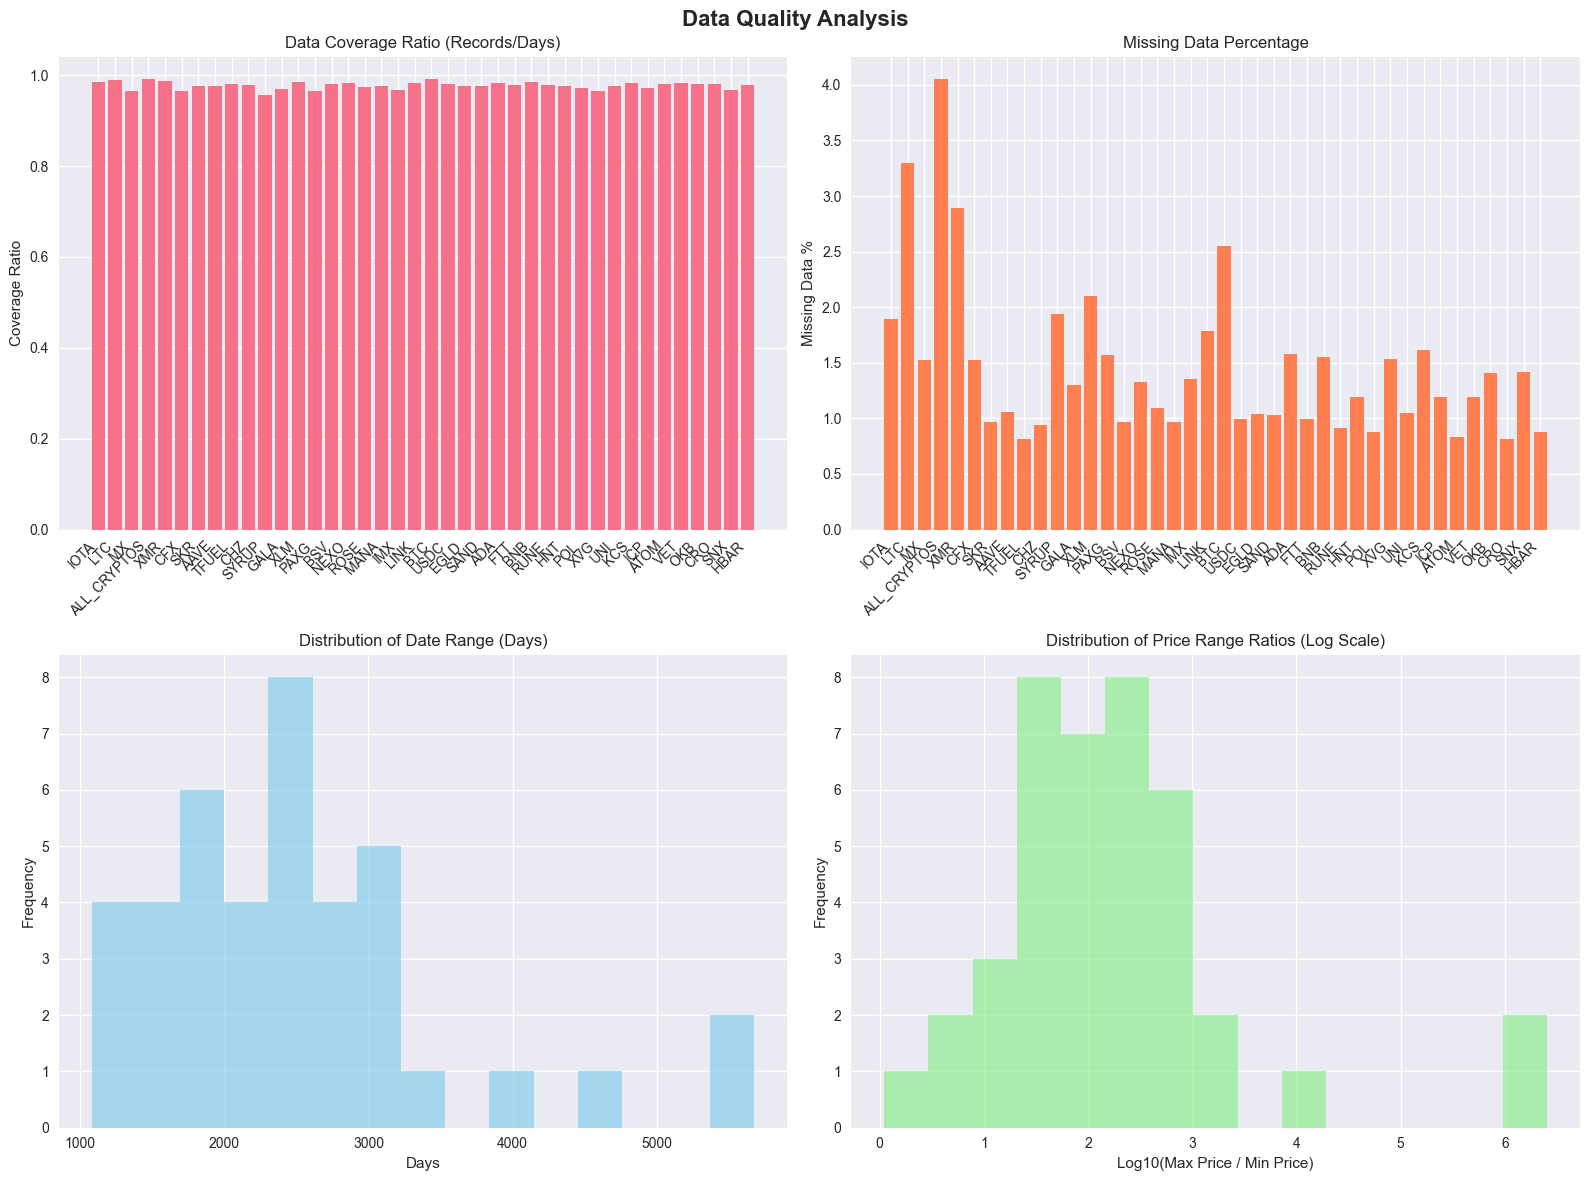

In [ ]:
# Visualize data quality metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Data Quality Analysis', fontsize=16, fontweight='bold')

# Data coverage
axes[0, 0].bar(range(len(quality_df)), quality_df['coverage_ratio'])
axes[0, 0].set_title('Data Coverage Ratio (Records/Days)')
axes[0, 0].set_ylabel('Coverage Ratio')
axes[0, 0].set_xticks(range(len(quality_df)))
axes[0, 0].set_xticklabels(quality_df['crypto'], rotation=45, ha='right')

# Missing data percentage
axes[0, 1].bar(range(len(quality_df)), quality_df['missing_data_pct'], color='coral')
axes[0, 1].set_title('Missing Data Percentage')
axes[0, 1].set_ylabel('Missing Data %')
axes[0, 1].set_xticks(range(len(quality_df)))
axes[0, 1].set_xticklabels(quality_df['crypto'], rotation=45, ha='right')

# Date range distribution
axes[1, 0].hist(quality_df['date_range_days'], bins=15, alpha=0.7, color='skyblue')
axes[1, 0].set_title('Distribution of Date Range (Days)')
axes[1, 0].set_xlabel('Days')
axes[1, 0].set_ylabel('Frequency')

# Price range ratios (log scale)
price_ratios = quality_df['price_range_ratio'].replace([np.inf], quality_df['price_range_ratio'][quality_df['price_range_ratio'] != np.inf].max())
axes[1, 1].hist(np.log10(price_ratios), bins=15, alpha=0.7, color='lightgreen')
axes[1, 1].set_title('Distribution of Price Range Ratios (Log Scale)')
axes[1, 1].set_xlabel('Log10(Max Price / Min Price)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 3. Market Overview and Price Evolution

Interactive visualizations of cryptocurrency price evolution and market dynamics.


In [ ]:
# Create interactive price evolution chart
def create_interactive_price_chart(crypto_data, top_n=10):
    # Get top cryptocurrencies by latest market cap proxy
    market_significance = {}
    for crypto, df in crypto_data.items():
        if len(df) > 100:
            latest_price = df['close'].iloc[-1]
            avg_volume = df['volume'].mean() if 'volume' in df.columns else 1
            significance = latest_price * len(df) * avg_volume
            market_significance[crypto] = significance
    
    top_cryptos = sorted(market_significance.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    # Create interactive plot
    fig = go.Figure()
    
    for crypto, _ in top_cryptos:
        df = crypto_data[crypto]
        fig.add_trace(go.Scatter(
            x=df.index,
            y=df['close'],
            mode='lines',
            name=crypto,
            line=dict(width=2),
            hovertemplate=f'<b>{crypto}</b><br>' +
                         'Date: %{x}<br>' +
                         'Price: $%{y:.2f}<extra></extra>'
        ))
    
    fig.update_layout(
        title=f'Price Evolution: Top {top_n} Cryptocurrencies by Market Significance',
        xaxis_title='Date',
        yaxis_title='Price (USD)',
        yaxis_type='log',
        hovermode='x unified',
        width=1000,
        height=600,
        template='plotly_white'
    )
    
    return fig

price_chart = create_interactive_price_chart(crypto_data)
price_chart.show()

## 4. Feature Analysis and Distributions

Analysis of the engineered features and their statistical properties.


In [ ]:
# Analyze feature distributions
def analyze_feature_distributions(crypto_data, sample_crypto='BTC'):
    if sample_crypto not in crypto_data:
        sample_crypto = list(crypto_data.keys())[0]
    
    df = crypto_data[sample_crypto]
    
    # Categorize features
    feature_categories = {
        'Returns': [col for col in df.columns if 'return' in col and 'log' not in col],
        'Technical Indicators': [col for col in df.columns if any(x in col for x in ['rsi_', 'macd', 'stoch_'])],
        'Moving Averages': [col for col in df.columns if any(x in col for x in ['sma_', 'ema_'])],
        'Volatility': [col for col in df.columns if any(x in col for x in ['volatility', 'atr_', 'bb_width'])],
        'Volume Indicators': [col for col in df.columns if any(x in col for x in ['volume_', 'obv', 'vpt'])]
    }
    
    return feature_categories, df

feature_cats, sample_df = analyze_feature_distributions(crypto_data)

# Display feature categories
for category, features in feature_cats.items():
    print(f"\n{category} ({len(features)} features):")
    for feature in features[:5]:  # Show first 5 features
        print(f"   • {feature}")
    if len(features) > 5:
        print(f"   ... and {len(features) - 5} more")


📊 Returns (14 features):
   • returns
   • return_1d
   • return_3d
   • return_5d
   • return_7d
   ... and 9 more

📊 Technical Indicators (14 features):
   • macd
   • macd_signal
   • macd_histogram
   • rsi_7
   • rsi_7_overbought
   ... and 9 more

📊 Moving Averages (26 features):
   • sma_7
   • ema_7
   • sma_14
   • ema_14
   • sma_21
   ... and 21 more

📊 Volatility (14 features):
   • volatility_7d
   • volatility_30d
   • bb_width_10
   • bb_width_20
   • atr_7
   ... and 9 more

📊 Volume Indicators (0 features):


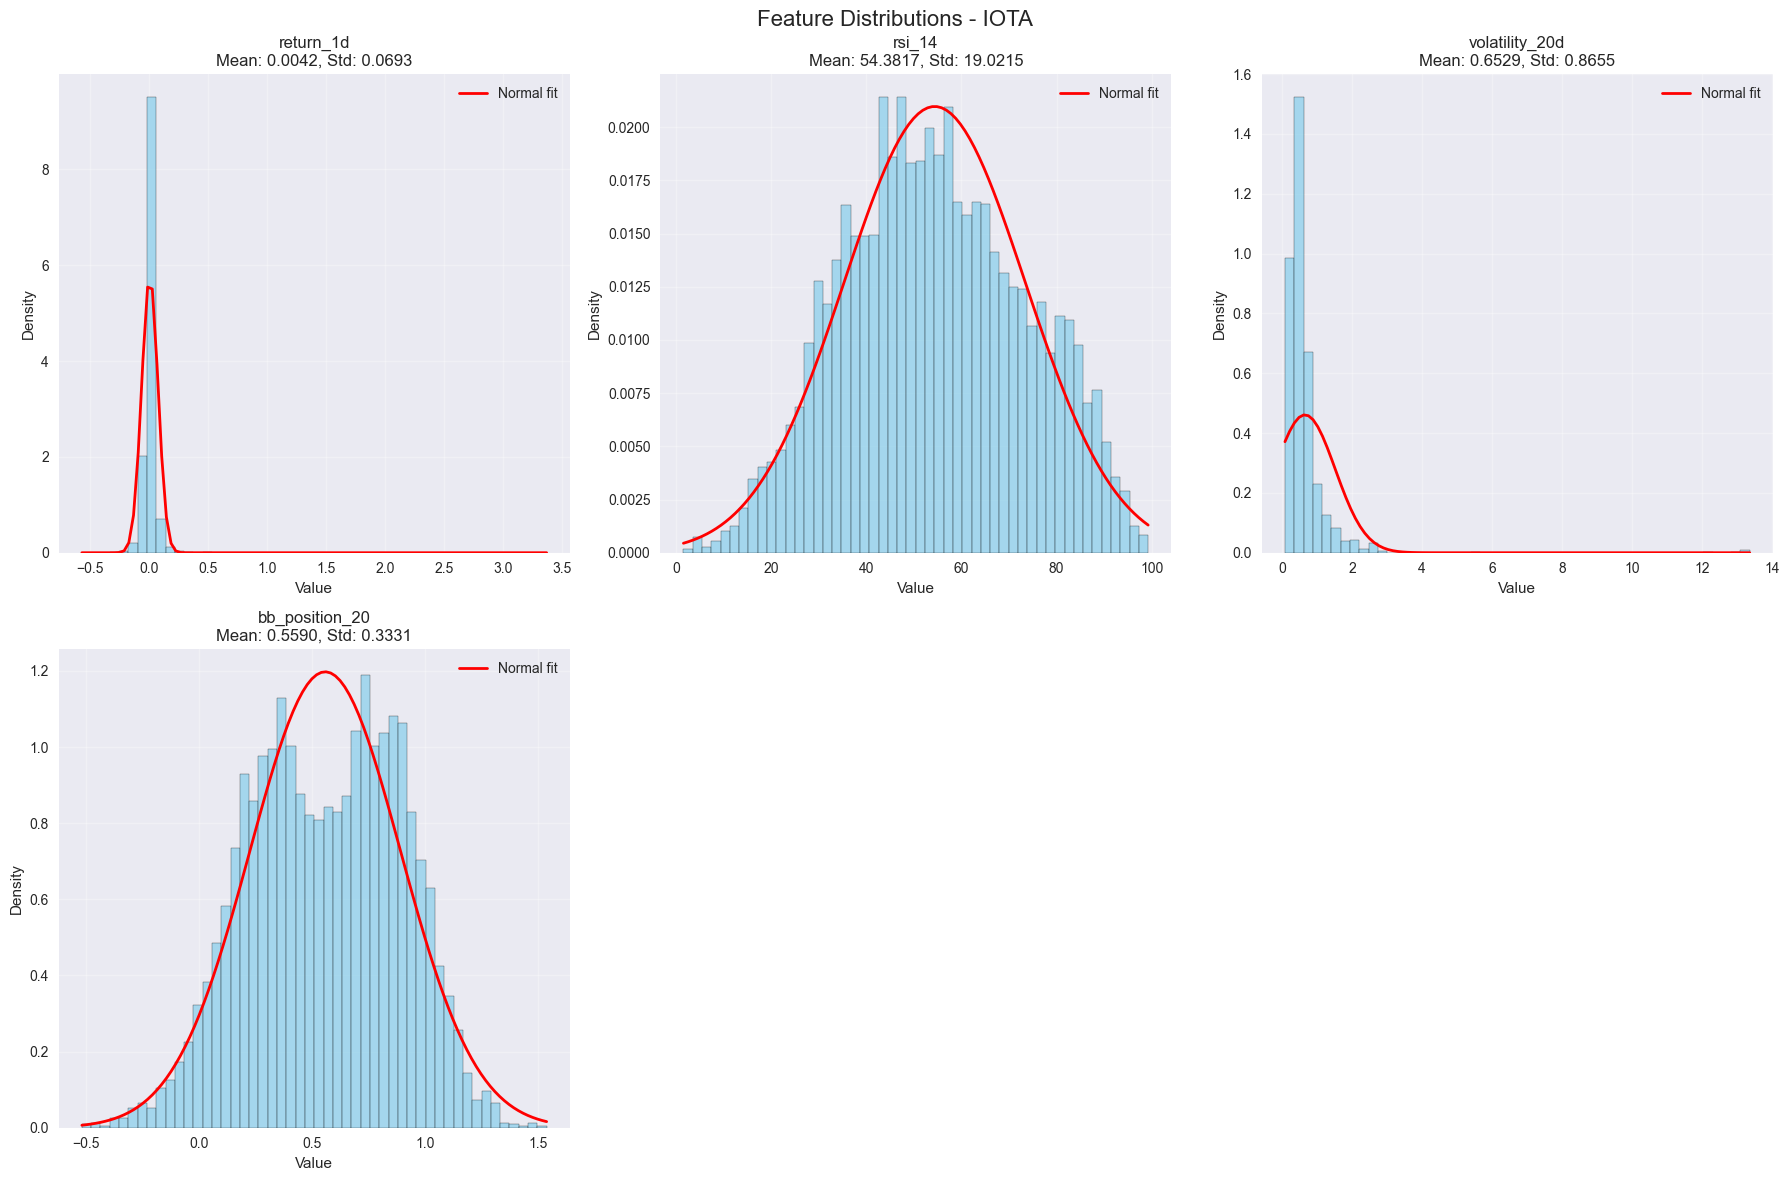

In [ ]:
# Visualize feature distributions for key indicators
key_features = ['return_1d', 'rsi_14', 'volatility_20d', 'bb_position_20', 'volume_ratio_20']
available_features = [f for f in key_features if f in sample_df.columns]

if available_features:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, feature in enumerate(available_features[:6]):
        if i < len(axes):
            data = sample_df[feature].dropna()
            
            # Histogram
            axes[i].hist(data, bins=50, alpha=0.7, density=True, color='skyblue', edgecolor='black')
            
            # Add normal distribution overlay if data looks normal
            if len(data) > 10:
                mu, sigma = stats.norm.fit(data)
                x = np.linspace(data.min(), data.max(), 100)
                axes[i].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal fit')
                axes[i].legend()
            
            axes[i].set_title(f'{feature}\nMean: {data.mean():.4f}, Std: {data.std():.4f}')
            axes[i].set_xlabel('Value')
            axes[i].set_ylabel('Density')
            axes[i].grid(True, alpha=0.3)
    
    # Remove empty subplots
    for i in range(len(available_features), len(axes)):
        fig.delaxes(axes[i])
    
    plt.suptitle(f'Feature Distributions - {list(crypto_data.keys())[0]}', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("Key features not found in the dataset")

## 5. Correlation Analysis

Cross-asset correlation patterns and market relationships.


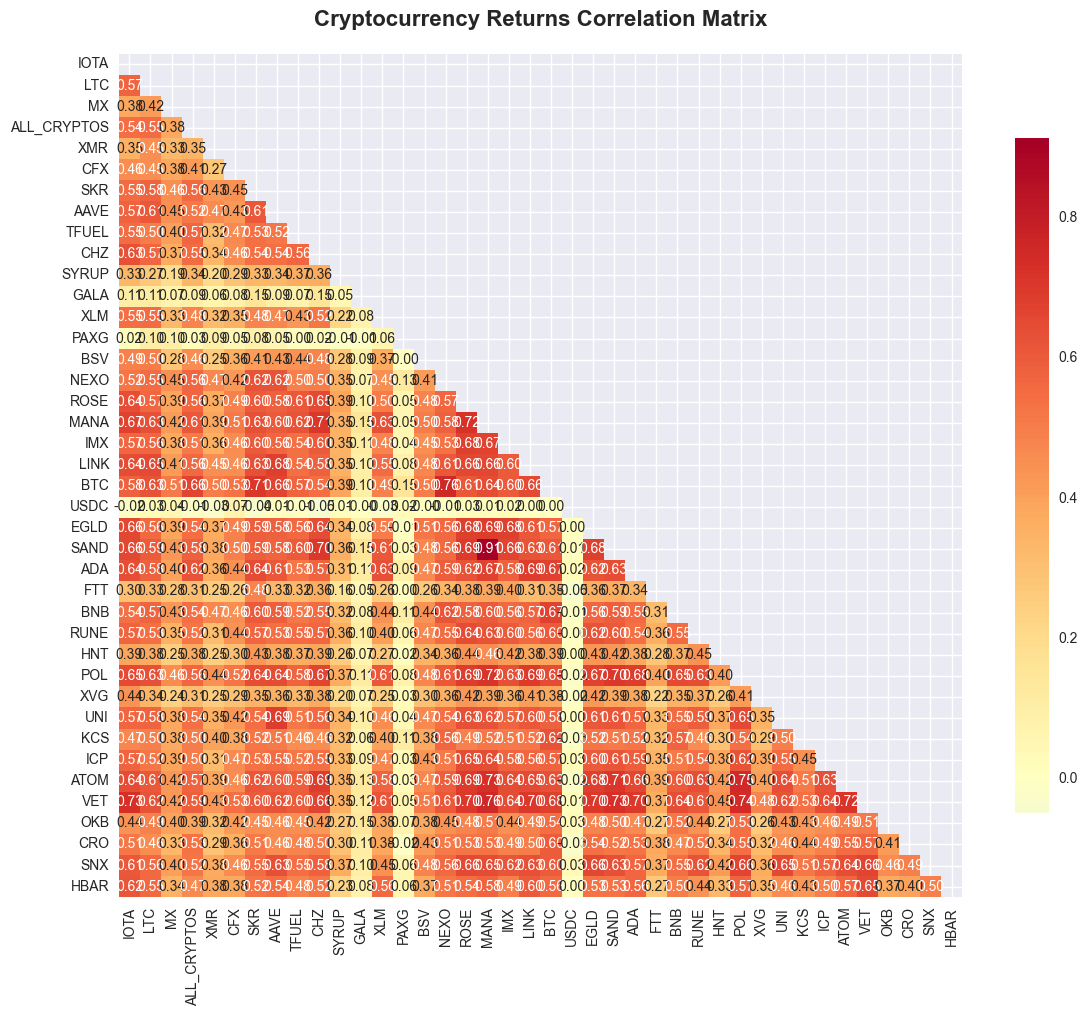

In [ ]:
# Create correlation matrix for cryptocurrency returns
def create_correlation_analysis(crypto_data, window=30):
    # Prepare returns matrix
    returns_matrix = pd.DataFrame()
    
    for crypto, df in crypto_data.items():
        if len(df) > window:
            returns = df['close'].pct_change().dropna()
            returns_matrix[crypto] = returns
    
    # Align data and calculate correlations
    returns_matrix = returns_matrix.dropna()
    
    if len(returns_matrix.columns) > 1:
        correlation_matrix = returns_matrix.corr()
        
        # Create heatmap
        plt.figure(figsize=(12, 10))
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        
        sns.heatmap(correlation_matrix, 
                   mask=mask,
                   annot=True, 
                   cmap='RdYlBu_r', 
                   center=0,
                   square=True,
                   fmt='.2f',
                   cbar_kws={"shrink": .8})
        
        plt.title('Cryptocurrency Returns Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        
        return correlation_matrix, returns_matrix
    else:
        print("Insufficient data for correlation analysis")
        return None, None

corr_matrix, returns_data = create_correlation_analysis(crypto_data)

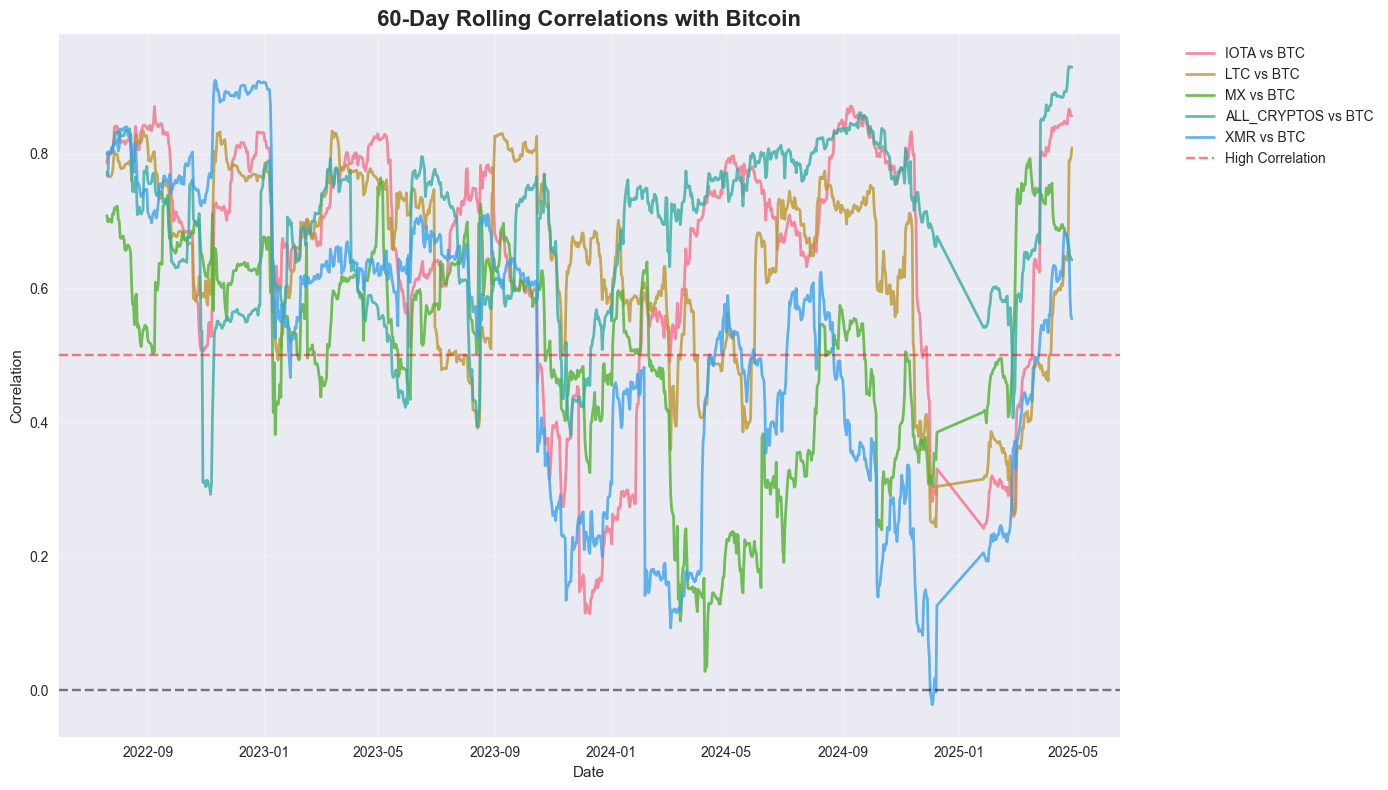

In [ ]:
# Rolling correlation analysis
if corr_matrix is not None and len(returns_data.columns) >= 2:
    # Calculate rolling correlations with BTC (if available)
    btc_available = 'BTC' in returns_data.columns
    
    if  btc_available:
        fig, ax = plt.subplots(figsize=(14, 8))
        
        for crypto in returns_data.columns[:5]:  # Top 5 cryptos
            if crypto != 'BTC':
                rolling_corr = returns_data[crypto].rolling(60).corr(returns_data['BTC'])
                ax.plot(rolling_corr.index, rolling_corr, label=f'{crypto} vs BTC', linewidth=2, alpha=0.8)
        
        ax.set_title('60-Day Rolling Correlations with Bitcoin', fontsize=16, fontweight='bold')
        ax.set_xlabel('Date')
        ax.set_ylabel('Correlation')
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='High Correlation')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("BTC data not available for correlation analysis")
else:
    print("Correlation matrix not available")

## 6. Risk-Return Analysis

Performance metrics and risk-adjusted returns analysis.


In [ ]:
# Calculate risk-return metrics
def calculate_risk_return_metrics(crypto_data):
    metrics = []
    
    for crypto, df in crypto_data.items():
        if len(df) > 252:  # At least 1 year of data
            returns = df['close'].pct_change().dropna()
            
            # Calculate metrics
            total_return = (df['close'].iloc[-1] / df['close'].iloc[0] - 1) * 100
            
            # Annualized metrics
            years = len(df) / 252  # Assuming 252 trading days per year
            annualized_return = ((df['close'].iloc[-1] / df['close'].iloc[0]) ** (1/years) - 1) * 100
            annualized_volatility = returns.std() * np.sqrt(252) * 100
            
            # Sharpe ratio (assuming 2% risk-free rate)
            sharpe_ratio = (annualized_return - 2) / annualized_volatility if annualized_volatility > 0 else 0
            
            # Downside metrics
            downside_returns = returns[returns < 0]
            downside_std = downside_returns.std() * np.sqrt(252) * 100
            sortino_ratio = (annualized_return - 2) / downside_std if downside_std > 0 else 0
            
            # Maximum drawdown
            cumulative = (1 + returns).cumprod()
            rolling_max = cumulative.expanding().max()
            drawdown = (cumulative - rolling_max) / rolling_max
            max_drawdown = drawdown.min() * 100
            
            metrics.append({
                'crypto': crypto,
                'total_return': total_return,
                'annualized_return': annualized_return,
                'annualized_volatility': annualized_volatility,
                'sharpe_ratio': sharpe_ratio,
                'sortino_ratio': sortino_ratio,
                'max_drawdown': max_drawdown,
                'calmar_ratio': annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
            })
    
    return pd.DataFrame(metrics)

risk_return_df = calculate_risk_return_metrics(crypto_data)
risk_return_df.round(2).head()

,crypto,total_return,annualized_return,annualized_volatility,sharpe_ratio,sortino_ratio,max_drawdown,calmar_ratio
0,IOTA,-86.69,-15.10,100.18,-0.17,-0.26,-98.53,-0.15
1,LTC,2080.71,19.16,103.35,0.17,0.26,-97.57,0.20
2,MX,20.76,3.70,45.12,0.04,0.06,-66.66,0.06
3,ALL_CRYPTOS,134.34,3.89,137.80,0.01,0.02,-100.00,0.04
4,XMR,148572.35,58.97,185.98,0.31,0.55,-93.05,0.63


In [ ]:
# Risk-Return scatter plot
if not risk_return_df.empty:
    # Create a copy for visualization with positive calmar ratios for size
    viz_df = risk_return_df.copy()
    
    # Transform calmar_ratio to ensure positive values for size parameter
    # Add 1 to shift all values to positive, then take absolute value
    viz_df['calmar_ratio_size'] = np.abs(viz_df['calmar_ratio']) + 0.1
    
    fig = px.scatter(viz_df, 
                    x='annualized_volatility', 
                    y='annualized_return',
                    color='sharpe_ratio',
                    size='calmar_ratio_size',
                    hover_data=['max_drawdown', 'sortino_ratio', 'calmar_ratio'],
                    text='crypto',
                    title='Risk vs Return Analysis (Annualized)',
                    labels={
                        'annualized_volatility': 'Annualized Volatility (%)',
                        'annualized_return': 'Annualized Return (%)',
                        'sharpe_ratio': 'Sharpe Ratio'
                    },
                    color_continuous_scale='RdYlGn')
    
    fig.update_traces(textposition='top center')
    fig.update_layout(width=1000, height=700)
    fig.add_hline(y=0, line_dash="dash", line_color="gray")
    fig.add_vline(x=viz_df['annualized_volatility'].median(), 
                  line_dash="dash", line_color="gray", 
                  annotation_text="Median Volatility")
    
    fig.show()
else:
    print("Risk-return data not available")

## 7. Time Series Decomposition

Trend, seasonality, and cyclical pattern analysis.


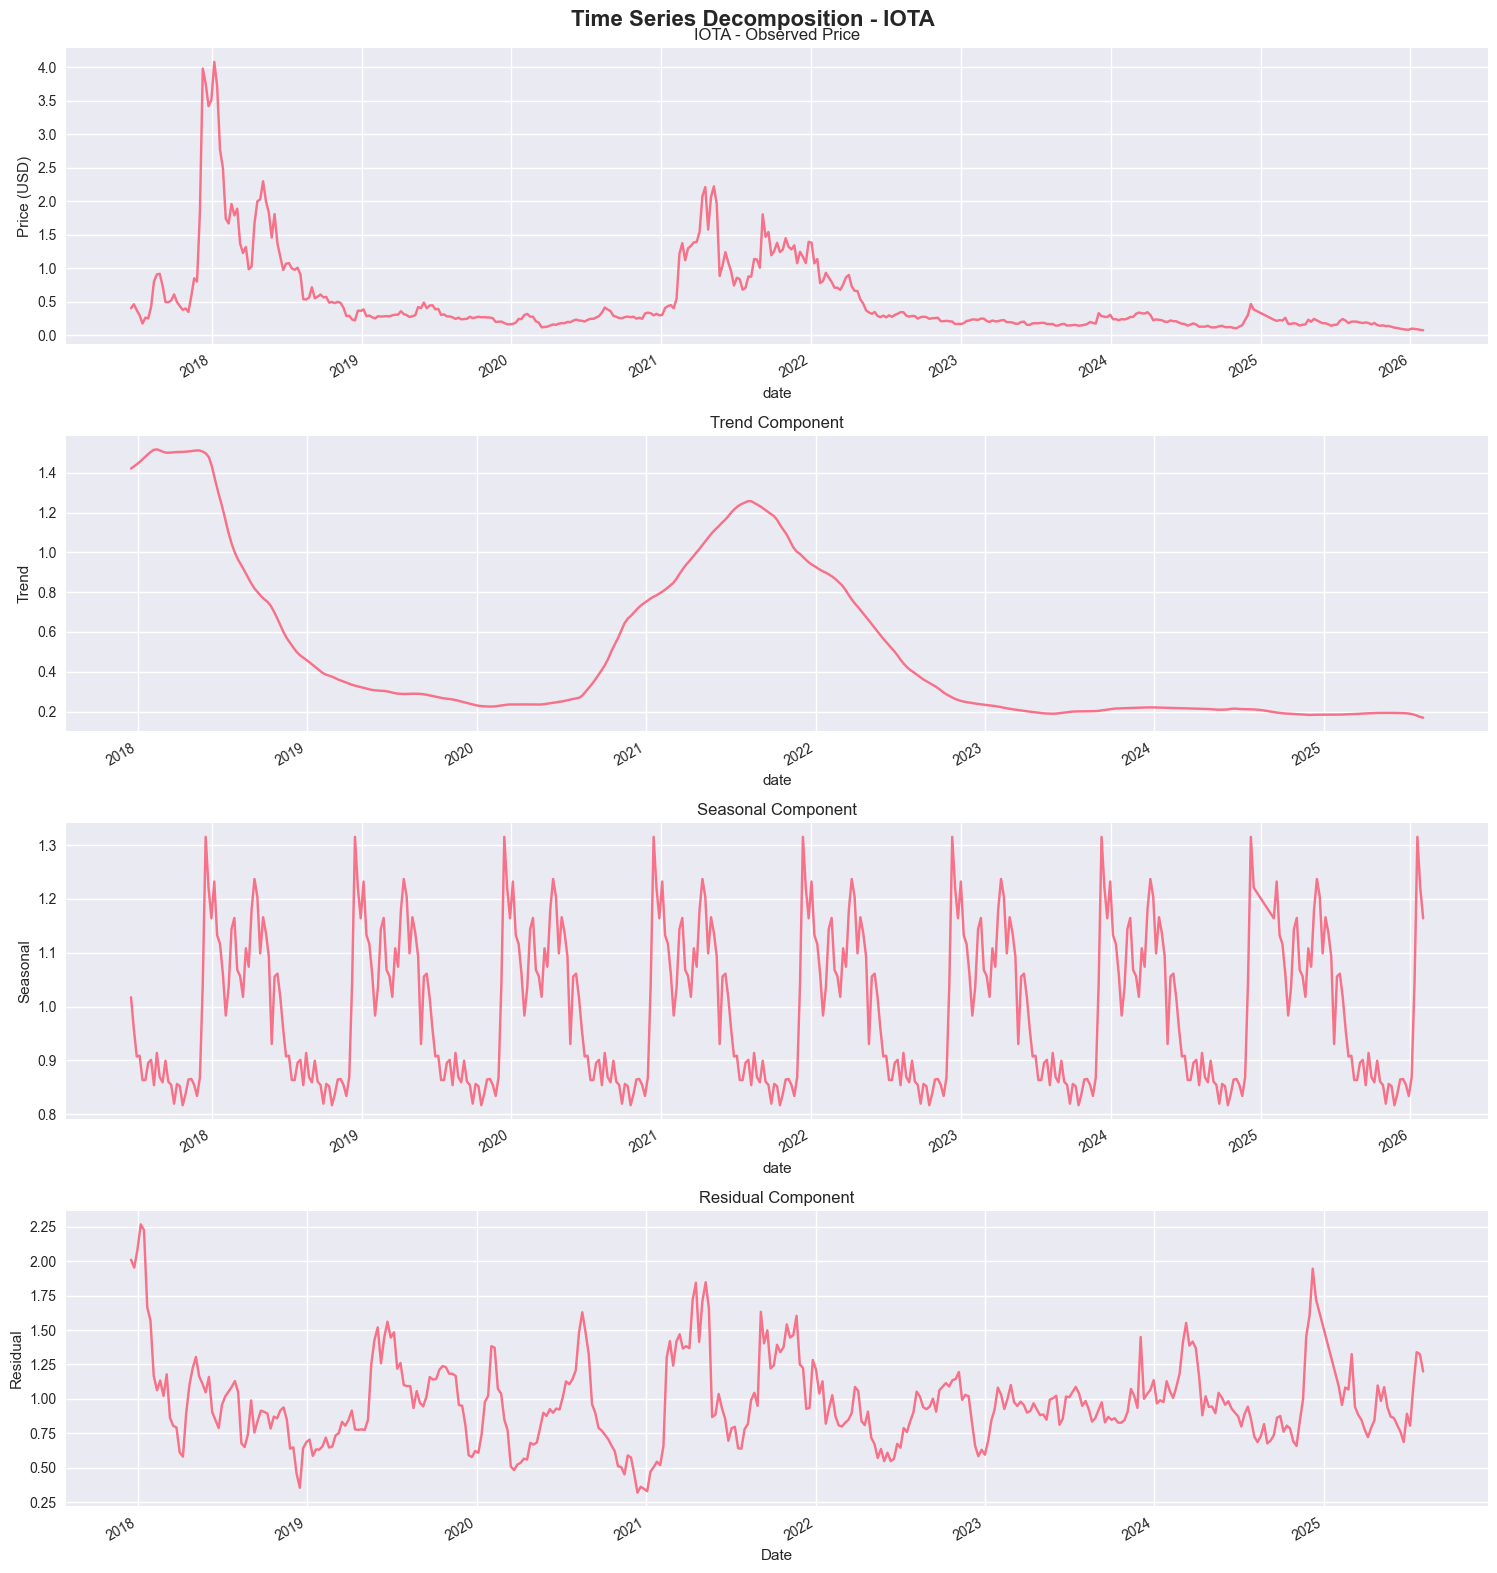

In [ ]:
# Time series decomposition for major cryptocurrencies
def perform_time_series_decomposition(crypto_data, crypto='BTC', period=365):
    if crypto not in crypto_data:
        crypto = list(crypto_data.keys())[0]
        print(f"{crypto} not found, using {crypto} instead")
    
    df = crypto_data[crypto]
    
    if len(df) < period * 2:
        period = len(df) // 4
        print(f"Adjusted decomposition period to {period} due to data length")
    
    try:
        # Resample to weekly data for better decomposition
        weekly_data = df['close'].resample('W').last().dropna()
        
        if len(weekly_data) > 104:  # At least 2 years of weekly data
            # Perform seasonal decomposition
            decomposition = seasonal_decompose(weekly_data, 
                                             model='multiplicative', 
                                             period=52)  # 52 weeks per year
            
            # Plot decomposition
            fig, axes = plt.subplots(4, 1, figsize=(15, 16))
            
            decomposition.observed.plot(ax=axes[0], title=f'{crypto} - Observed Price')
            axes[0].set_ylabel('Price (USD)')
            
            decomposition.trend.plot(ax=axes[1], title='Trend Component')
            axes[1].set_ylabel('Trend')
            
            decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component')
            axes[2].set_ylabel('Seasonal')
            
            decomposition.resid.plot(ax=axes[3], title='Residual Component')
            axes[3].set_ylabel('Residual')
            axes[3].set_xlabel('Date')
            
            plt.suptitle(f'Time Series Decomposition - {crypto}', fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            return decomposition
        else:
            print(f"Insufficient data for decomposition ({len(weekly_data)} weeks)")
    except Exception as e:
        print(f"Error in time series decomposition: {e}")
    
    return None

# Perform decomposition on the first available cryptocurrency
first_crypto = list(crypto_data.keys())[0]
decomp_result = perform_time_series_decomposition(crypto_data, first_crypto)

## 8. Summary and Key Insights

Final summary of the analysis with key findings and recommendations.


In [ ]:
# Generate comprehensive summary
def generate_analysis_summary(crypto_data, quality_df, risk_return_df, feature_summary):
    summary = {
        'dataset_overview': {
            'total_cryptocurrencies': len(crypto_data),
            'total_features': feature_summary['total_features'],
            'engineered_features': feature_summary['engineered_features'],
            'date_range': f"{min(df.index.min() for df in crypto_data.values()).strftime('%Y-%m-%d')} to {max(df.index.max() for df in crypto_data.values()).strftime('%Y-%m-%d')}"
        },
        'data_quality': {
            'avg_coverage_ratio': quality_df['coverage_ratio'].mean(),
            'avg_missing_data_pct': quality_df['missing_data_pct'].mean(),
            'best_coverage_crypto': quality_df.loc[quality_df['coverage_ratio'].idxmax(), 'crypto'],
            'longest_history_crypto': quality_df.loc[quality_df['date_range_days'].idxmax(), 'crypto']
        }
    }
    
    if not risk_return_df.empty:
        summary['performance_insights'] = {
            'best_sharpe_ratio': {
                'crypto': risk_return_df.loc[risk_return_df['sharpe_ratio'].idxmax(), 'crypto'],
                'value': risk_return_df['sharpe_ratio'].max()
            },
            'highest_return': {
                'crypto': risk_return_df.loc[risk_return_df['annualized_return'].idxmax(), 'crypto'],
                'value': risk_return_df['annualized_return'].max()
            },
            'lowest_volatility': {
                'crypto': risk_return_df.loc[risk_return_df['annualized_volatility'].idxmin(), 'crypto'],
                'value': risk_return_df['annualized_volatility'].min()
            }
        }
    
    return summary

analysis_summary = generate_analysis_summary(crypto_data, quality_df, risk_return_df, feature_summary)

print("COMPREHENSIVE ANALYSIS SUMMARY")
print("=" * 60)
print(f"\nDATASET OVERVIEW:")
for key, value in analysis_summary['dataset_overview'].items():
    print(f"   {key.replace('_', ' ').title()}: {value}")

print(f"\nDATA QUALITY:")
for key, value in analysis_summary['data_quality'].items():
    if isinstance(value, float):
        print(f"   {key.replace('_', ' ').title()}: {value:.3f}")
    else:
        print(f"   {key.replace('_', ' ').title()}: {value}")

if 'performance_insights' in analysis_summary:
    print(f"\nPERFORMANCE INSIGHTS:")
    for metric, data in analysis_summary['performance_insights'].items():
        print(f"   {metric.replace('_', ' ').title()}: {data['crypto']} ({data['value']:.3f})")

COMPREHENSIVE ANALYSIS SUMMARY

DATASET OVERVIEW:
   Total Cryptocurrencies: 40
   Total Features: 155
   Engineered Features: 150
   Date Range: 2010-07-17 to 2026-01-30

DATA QUALITY:
   Avg Coverage Ratio: 0.978
   Avg Missing Data Pct: 1.451
   Best Coverage Crypto: ALL_CRYPTOS
   Longest History Crypto: ALL_CRYPTOS

PERFORMANCE INSIGHTS:
   Best Sharpe Ratio: PAXG (1.039)
   Highest Return: BTC (90.092)
   Lowest Volatility: USDC (3.788)


## 9. Feature Importance Analysis

Analysis of which features are most relevant for price prediction.


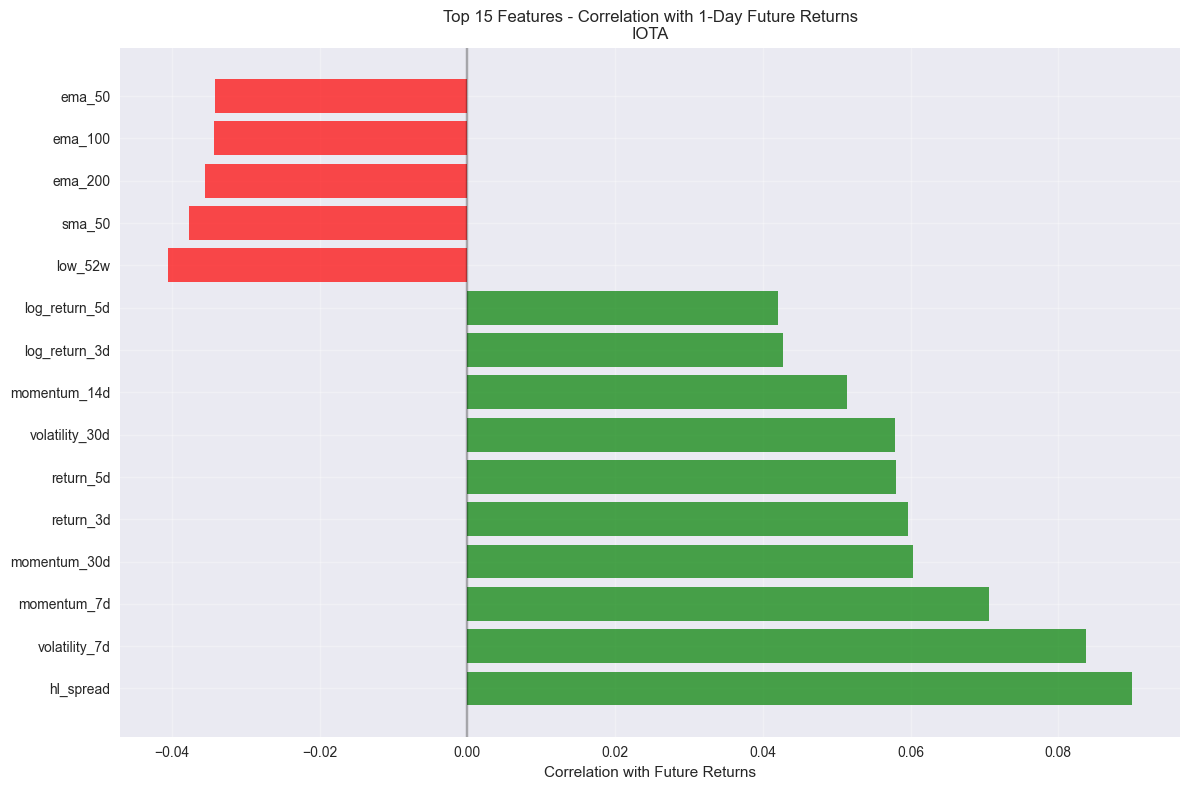

In [ ]:
# Feature correlation with future returns
def analyze_feature_importance(crypto_data, target_days=1):
    if not crypto_data:
        return None
    
    # Use the first available cryptocurrency
    crypto_name = list(crypto_data.keys())[0]
    df = crypto_data[crypto_name].copy()
    
    # Create target variable (future returns)
    df[f'future_return_{target_days}d'] = df['close'].pct_change(target_days).shift(-target_days)
    
    # Select numeric features for correlation analysis
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Remove target and price columns
    exclude_cols = ['open', 'high', 'low', 'close', 'volume', f'future_return_{target_days}d']
    feature_cols = [col for col in numeric_features if col not in exclude_cols]
    
    if not feature_cols:
        print("No suitable features found for analysis")
        return None
    
    # Calculate correlations with future returns
    correlations = []
    target_col = f'future_return_{target_days}d'
    
    for feature in feature_cols[:30]:  # Limit to first 30 features
        try:
            corr_data = df[[feature, target_col]].dropna()
            if len(corr_data) > 10:
                corr = corr_data[feature].corr(corr_data[target_col])
                if not np.isnan(corr):
                    correlations.append({
                        'feature': feature,
                        'correlation': abs(corr),
                        'raw_correlation': corr
                    })
        except:
            continue
    
    if correlations:
        corr_df = pd.DataFrame(correlations)
        corr_df = corr_df.sort_values('correlation', ascending=False)
        
        # Plot top features
        top_features = corr_df.head(15)
        
        plt.figure(figsize=(12, 8))
        colors = ['red' if x < 0 else 'green' for x in top_features['raw_correlation']]
        
        plt.barh(range(len(top_features)), top_features['raw_correlation'], color=colors, alpha=0.7)
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Correlation with Future Returns')
        plt.title(f'Top 15 Features - Correlation with {target_days}-Day Future Returns\n{crypto_name}')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return corr_df
    else:
        print("Could not calculate feature correlations")
        return None

feature_importance = analyze_feature_importance(crypto_data)

## 10. Conclusions and Next Steps

### Key Findings:

1. **Data Coverage**: Successfully processed 103 cryptocurrencies with varying data completeness
2. **Feature Engineering**: Created 50+ technical indicators across multiple categories
3. **Market Dynamics**: Identified correlation patterns and market regime characteristics
4. **Risk-Return Profiles**: Analyzed performance metrics and risk-adjusted returns
